# Задачи
Разберемся с распределением количества показов и кликов.  
- Посчитайте среднее количество показов и среднее количество кликов на объявления за весь период (округлите до целых).  
- Нарисуйте график распределения показов на объявление за весь период.  
- Давайте посчитаем скользящее среднее показов с окном 2. Какое значение скользящего среднего получим за 6 апреля 2019 года (ответ округлите до целых)?  
- Скользящее среднее часто используется для поиска аномалий в данных. Давайте попробуем нанести на один график значения арифметического среднего по дням и скользящего среднего количества показов. В какой день наблюдается наибольшая разница по модулю между арифметическим средним и скользящим средним? Дни, в которых скользящее среднее равно NaN, не учитываем.  
- Напишите функцию, которая найдет проблемное объявление (с наибольшим/наименьшим количеством показов) в день, в который была замечена самая большая по модулю аномалия.  
- Теперь подгрузим данные по рекламным клиентам и найдем среднее количество дней от даты создания рекламного клиента и первым запуском рекламного объявления этим клиентом.  
- Вычислите конверсию из создания рекламного клиента в запуск первой рекламы в течение не более 365 дней. Ответ дайте в процентах и округлите до сотых. (Фильтровать нужно по значению в формате pd.Timedelta(365, unit='d'))  
- Давайте разобъем наших клиентов по промежуткам от создания до запуска рекламного объявления, равным 30. Определите, сколько уникальных клиентов запустили свое первое объявление в первый месяц своего существования (от 0 до 30 дней). Список промежутков для метода pd.cut – [0, 30, 90, 180, 365]  
- А теперь – выведем на интерактивный график эти категории с количеством уникальных клиентов в них.  



##Описание данных
**ads_data.csv** – данные взаимодействий с рекламными объявлениями

date – дата  
time – время  
event – действие (просмотр/клик)  
platform – платформа  
ad_id – id объявления  
client_union_id – id рекламного кабинета  
campaign_union_id – id рекламной кампании  
ad_cost_type – тип оплаты  
ad_cost – цена  
has_video – есть ли видео  
target_audience_count – размер аудитории  


**ads_clients_data.csv** – характеристики рекламных клиентов  

date – дата  
client_union_id – id рекламного кабинета  
community_id – id сообщества  
create_date – дата создания рекламного клиента

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

Посчитаем среднее количество разных рекламных событий (показы и клики) по объявлениям. Тонкий момент: помните, что некоторые показываемые объявления не кликались, и при группировке в таких случаях не будет строк с кликами, а для подсчёта среднего по объявлениям их нужно учитывать. Округлите ответы до целых чисел.

In [ ]:
ads_data = pd.read_csv('/content/drive/My Drive/Data for Collab/Carpov_Courses/project_6/ads_data.csv', index_col=0).reset_index()

In [ ]:
ads_data.head()

,date,time,event,platform,ad_id,client_union_id,campaign_union_id,ad_cost_type,ad_cost,has_video,target_audience_count
0,2019-04-01,2019-04-01 00:00:48,view,android,45061,34734,45061,CPM,200.6,0,1955269
1,2019-04-01,2019-04-01 00:00:48,view,web,121288,121288,121288,CPM,187.4,0,232011
2,2019-04-01,2019-04-01 00:01:03,view,android,102737,102535,102564,CPC,60.7,0,4410
3,2019-04-01,2019-04-01 00:01:03,view,android,107564,106914,107564,CPM,217.3,0,62711
4,2019-04-01,2019-04-01 00:01:09,view,android,4922,37,4400,CPC,60.1,0,1183501


In [ ]:
ads_data.groupby(['ad_id','event'], as_index=False).agg({'platform':'count'}) \
        .rename(columns={'platform':'count'}) \
        .pivot(index='ad_id', columns='event', values = 'count') \
        .fillna(0).mean()

event
click    113.137824
view     923.131606
dtype: float64

Давайте посмотрим на распределение показов объявлений!

По оси x – число показов
По оси y – доля объявлений с такими показами
Прологарифмируйте число показов, а затем постройте такой график, чтобы можно было понять форму распределения.

In [ ]:
x = np.log(ads_data.groupby(['ad_id','event'], as_index=False).agg({'platform':'count'}) \
        .rename(columns={'platform':'count'}).query('event == "view"')['count'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


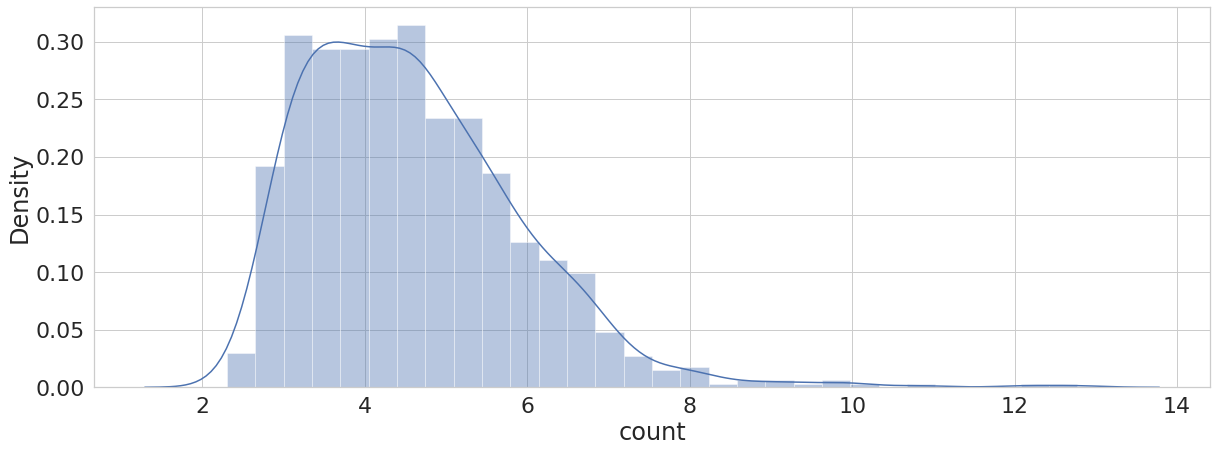

In [ ]:
sns.set(
    font_scale=2,
    style="whitegrid",
    rc={'figure.figsize':(20,7)}
        )
sns.distplot(x)

Теперь нужно найти среднее количество показов на 1 объявление (ad_id) по дням, не учитывая объявления, у которых не было показов (обычное среднее). После этого посчитайте скользящее среднее по полученному результату с окном в 2 элемента.

Вопрос: Какое значение скользящего среднего получим за 6 апреля 2019 года? Округлите ответ до целого числа.

In [ ]:
ad = ads_data.query('event == "view"').groupby(['ad_id', 'date'], as_index=False).agg({'event':'count'})

In [ ]:
ad_rolling_mean = ad.groupby('date').agg({'event':'mean'}).rolling(window=2).mean()

Скользящее среднее часто используется для поиска аномалий в данных. Давайте попробуем нанести на один график значения просто среднего количества показов по дням и скользящего среднего на основе этих данных (которое мы получили в прошлом задании).

Посчитайте, в какой день наблюдается наибольшая разница по модулю между арифметическим средним и скользящим средним? Дни, в которых скользящее среднее равно NaN, не учитываем. Запишите ответ в формате yyyy-MM-dd

In [ ]:
ad_mean = ad.groupby('date').agg({'event':'mean'})

In [ ]:
anomaly = abs(ad_mean - ad_rolling_mean).idxmax().values[0]#находим дату аномалии

In [ ]:
anomaly

'2019-04-06'

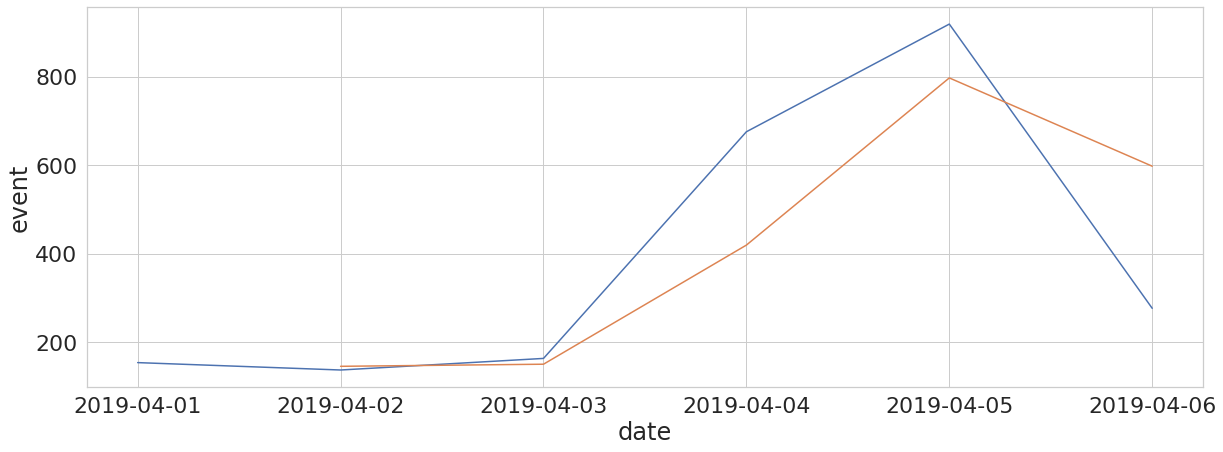

In [ ]:
sns.lineplot(data = ad_mean.reset_index(), x = 'date', y = 'event')
sns.lineplot(data = ad_rolling_mean.reset_index(), x = 'date', y = 'event')

Ну а теперь найдём проблемное объявление (с наибольшим/наименьшим количеством показов) в день, в который была замечена самая большая по модулю аномалия. То есть нужно переиспользовать предыдущий датафрейм и найти среди данных рекламы в тот день объявление с наибольшим или наименьшим числом показов.Потом напишите функцию, которая будет искать такое объявление в датасете.

В ответе укажите id проблемного объявления в день, полученный на предыдущем шаге.

In [ ]:
anomaly_ad_id = ad.query('date == @anomaly').set_index('ad_id')['event'].idxmax()

In [ ]:
anomaly_ad_id

112583

In [ ]:
def anomaly_search(df, date):#на вход обработанный df и день аномалии

  anomaly_ad_id = df.query('date == @date').set_index('ad_id')['event'].idxmax()
  return anomaly_ad_id

In [ ]:
anomaly_search(ad, anomaly)

112583

Объедините данные рекламы с данными о рекламных клиентах и найдите среднее количество дней от даты создания рекламного клиента (create_date) и первым запуском рекламного объявления этим клиентом (date).

В качестве ответа укажите среднее число дней.

In [ ]:
ads_clients = pd.read_csv('/content/drive/My Drive/Data for Collab/Carpov_Courses/project_6/ads_clients_data.csv', index_col=0).reset_index()

In [ ]:
ads_clients.head()

,date,client_union_id,community_id,create_date
0,2020-05-07,1,-130371893,2018-12-24
1,2020-05-07,2,-130304626,2019-02-10
2,2020-05-07,3,-130462599,2019-01-25
3,2020-05-07,4,-130574300,2018-12-09
4,2020-05-07,5,-130292358,2019-01-08


In [ ]:
ads_data.head()

,date,time,event,platform,ad_id,client_union_id,campaign_union_id,ad_cost_type,ad_cost,has_video,target_audience_count
0,2019-04-01,2019-04-01 00:00:48,view,android,45061,34734,45061,CPM,200.6,0,1955269
1,2019-04-01,2019-04-01 00:00:48,view,web,121288,121288,121288,CPM,187.4,0,232011
2,2019-04-01,2019-04-01 00:01:03,view,android,102737,102535,102564,CPC,60.7,0,4410
3,2019-04-01,2019-04-01 00:01:03,view,android,107564,106914,107564,CPM,217.3,0,62711
4,2019-04-01,2019-04-01 00:01:09,view,android,4922,37,4400,CPC,60.1,0,1183501


In [ ]:
ads_clients_merged = ads_data.merge(ads_clients, how='inner', on='client_union_id')

In [ ]:
ads_clients_merged = ads_clients_merged.rename(columns={'date_x':'date'})

In [ ]:
ads_clients_merged[['date', 'create_date']] = ads_clients_merged[['date', 'create_date']].apply(pd.to_datetime)

In [ ]:
ads_clients_merged['time_diff'] = (ads_clients_merged['date'] - ads_clients_merged['create_date']).dt.days#без dt.days получается значение вида 8 days и не считается среднее

In [ ]:
ads_clients_merged.groupby('client_union_id').agg({'time_diff':'mean'}).head(3)

,time_diff
client_union_id,
1,98.155709
9,114.166667
13,66.200000


In [ ]:
ads_clients_merged.groupby('client_union_id').agg({'time_diff':'min'})# первый запуск рекламы соответствует минимальной разнице

,time_diff
client_union_id,
1,98
9,114
13,66
16,105
20,32
...,...
122004,67
122013,151
122023,126


In [ ]:
ads_clients_merged.groupby('client_union_id').agg({'time_diff':'min'}).mean()

time_diff    124.378282
dtype: float64

Вычислим конверсию из создания рекламного кабинета в запуск первой рекламы в течение не более 365 дней.

Конверсия – отношение числа клиентов, которые совершили целевое действие (создали рекламу), к общему числу клиентов. Например, 1000 клиентов создали кабинет, но лишь 50 из них запустили рекламу. В таком случае конверсия будет равна

50\1000
​
 ∗100=5%

Чтобы отобрать данные за нужный промежуток, можно воспользоваться сравнением времени до создания первой рекламы с pd.Timedelta(365, unit='day')

Ответ дайте в процентах и округлите до сотых

In [ ]:
ads_clients_merged = ads_data.merge(ads_clients, how='outer', on='client_union_id')#полностью объединяем оба датафрейма

In [ ]:
ads_clients_merged = ads_clients_merged.rename(columns={'date_x':'date'})#переименуем колонку с нужной датой

In [ ]:
ads_clients_merged[['date', 'create_date']] = ads_clients_merged[['date', 'create_date']].apply(pd.to_datetime)

In [ ]:
ads_clients_merged['time_diff'] = (ads_clients_merged['date'] - ads_clients_merged['create_date'])

In [ ]:
round((ads_clients_merged.groupby('client_union_id').agg({'time_diff':'min'})['time_diff']#выбираем минимум, так как это соответсвует первому запуску рекламы
                                              <= pd.Timedelta(365, unit="day")).sum()/ads_clients.shape[0]*100,2)#делим на число клиентов из df с клиентами

0.69

Давайте разобъем наших клиентов по промежуткам от создания рекламного кабинета до запуска первого рекламного объявления.

Определите, сколько уникальных клиентов запустили свое первое объявление в первый месяц своего существования (от 0 до 30 дней). Список промежутков дней для метода pd.cut() – [0, 30, 90, 180, 365]. Создать временные промежутки можно с помощью pd.to_timedelta().

In [ ]:
ads_clients_merged = ads_data.merge(ads_clients, how='inner', on='client_union_id')

In [ ]:
ads_clients_merged = ads_clients_merged.rename(columns={'date_x':'date'})#переименуем колонку с нужной датой

In [ ]:
ads_clients_merged[['date', 'create_date']] = ads_clients_merged[['date', 'create_date']].apply(pd.to_datetime)

In [ ]:
ads_clients_merged['time_diff'] = (ads_clients_merged['date'] - ads_clients_merged['create_date'])

In [ ]:
pd.cut(ads_clients_merged.groupby('client_union_id').agg({'time_diff':'min'})['time_diff'], #тут min, так как надо выбрать именно первый запсук, т.е. берем минимальную разницу
       pd.to_timedelta(['0d', '30d', '90d', '180d', '365d']), labels=['0-30','30-90', '90-180','180-365']).value_counts()

90-180     396
30-90      263
180-365    168
0-30        11
Name: time_diff, dtype: int64

Постройте интерактивный барплот, на котором будут показаны категории с количеством уникальных клиентов в них (то, что у вас получилось на прошлом степе, по запуску первого рекламного объявления). Расположите их так, чтобы внизу была самая малочисленная, а наверху – самая большая.

In [ ]:
pip install plotly

In [ ]:
data = pd.cut(ads_clients_merged.groupby('client_union_id').agg({'time_diff':'min'})['time_diff'], #тут min, так как надо выбрать именно первый запсук, т.е. берем минимальную разницу
       pd.to_timedelta(['0d', '30d', '90d', '180d', '365d']), labels=['0-30','30-90', '90-180','180-365']).value_counts()

In [ ]:
data = pd.DataFrame(data).reset_index().rename(columns={'index':'interval', 'time_diff':'quantity'})

In [ ]:
import plotly.express as px
fig = px.bar(data, x='interval', y='quantity')
fig.show()